In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/regression_image_dataset.zip'  # Replace with actual zip path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Step 3: Set Paths
image_folder = '/content/dataset/images'  # change this path
csv_file = '/content/dataset/labels.csv'  # change this path

In [4]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Step 4: Load CSV and filter out 'undipped' (-1.0) rows
df = pd.read_csv(csv_file)
df = df[df['label'] != -1.0].reset_index(drop=True)  # Filter out label = -1.0

# Step 5: Load Images and Labels
image_size = (224, 224) # Adjusted to match model input size
X, y = [], []

for index, row in df.iterrows():
    img_path = os.path.join(image_folder, row['filename'])  # column should be named 'filename'
    label = row['label']
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [5]:
# STEP 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# STEP 5: Aggressive fine-tuning for NASNetMobile regression
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf

IMG_SIZE = 224   # NASNetMobile uses 224x224

# Load NASNetMobile backbone
base_model = NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True   # allow full fine-tuning

# Freeze early low-level layers (NASNet has 804 layers!)
# Freezing first ~200 keeps training stable
for layer in base_model.layers[-200:]:
    layer.trainable = True
for layer in base_model.layers[:-200]:
    layer.trainable = False

# Regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)

output = Dense(1)(x)   # regression output

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile with small LR for stable fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_mae', patience=70, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=10, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_nasnetmobile_reg_finetuned.h5", save_best_only=True, monitor="val_mae", mode="min")
]

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_188[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_189[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_191[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_190[0

 Total params: 4,982,549 (19.01 MB)

 Trainable params: 3,412,545 (13.02 MB)

 Non-trainable params: 1,570,004 (5.99 MB)

In [9]:
# Directly train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32
)


Epoch 1/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 694ms/step - loss: 98.1497 - mae: 9.0690 - val_loss: 77.8179 - val_mae: 7.8987
Epoch 2/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 98.3292 - mae: 9.0426 - val_loss: 80.7142 - val_mae: 8.0824
Epoch 3/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 97.2021 - mae: 9.0612 - val_loss: 82.4055 - val_mae: 8.1920
Epoch 4/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 98.2029 - mae: 9.0774 - val_loss: 83.6675 - val_mae: 8.2764
Epoch 5/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 92.9742 - mae: 8.8391 - val_loss: 84.6682 - val_mae: 8.3468
Epoch 6/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 89.8607 - mae: 8.6725 - val_loss: 85.5815 - val_mae: 8.4102
Epoch 7/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 91.6029 - mae: 8.7893 - val_loss: 86.0357 - val_mae: 8.4507
Epoch 8/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 88.1749 - mae: 8.6086 - val_loss: 85.8648 - val_mae: 8.4563
Epoch 9/2000
54/54 ━━━━━━━━━━

In [10]:
# STEP 7 (UPDATED): Evaluate and predict with MAE, MSE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate on validation set
y_pred = model.predict(X_val).flatten()

# Metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
Mean Absolute Error (MAE): 0.8252
Mean Squared Error (MSE): 1.7319
Root Mean Squared Error (RMSE): 1.3160
R² Score: 0.8867


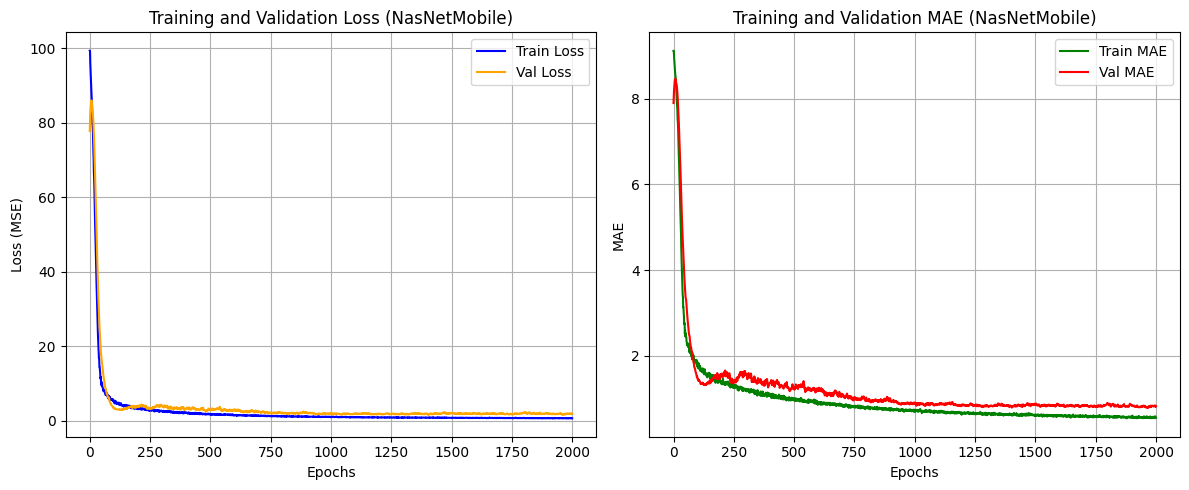

In [12]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (NasNetMobile)')
plt.legend()
plt.grid(True)

# Plot MAE
if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color='green')
    plt.plot(history.history['val_mae'], label='Val MAE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE (NasNetMobile)')
    plt.legend()
    plt.grid(True)
else:
    print("⚠️ MAE not found in history. Did you compile the model with `metrics=['mae']`?")

plt.tight_layout()
plt.savefig("NasNetMobile_loss_and_mae_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()


In [13]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': y_pred.flatten()})

# Save locally in Colab
csv_path = '/content/NasNetMobile_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

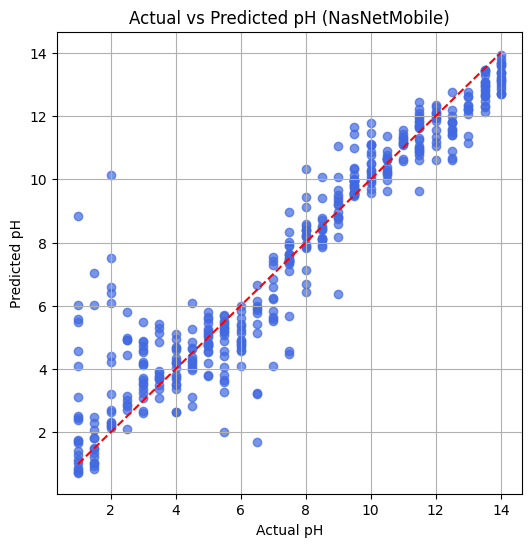

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.7, color='royalblue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs Predicted pH (NasNetMobile)")
plt.grid(True)
plt.savefig("NasNetMobile_actualvspredicted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

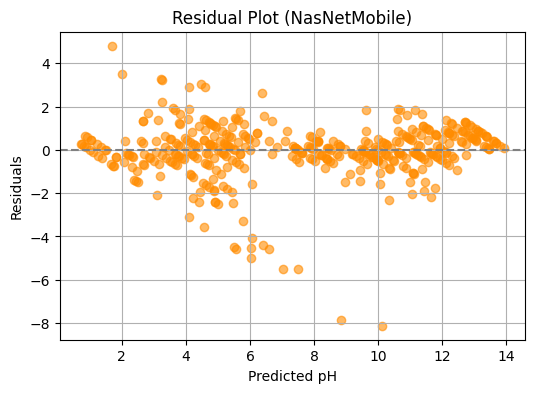

In [15]:
residuals = y_val - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pH")
plt.ylabel("Residuals")
plt.title("Residual Plot (NasNetMobile)")
plt.grid(True)
plt.savefig("NasNetMobile_residual_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

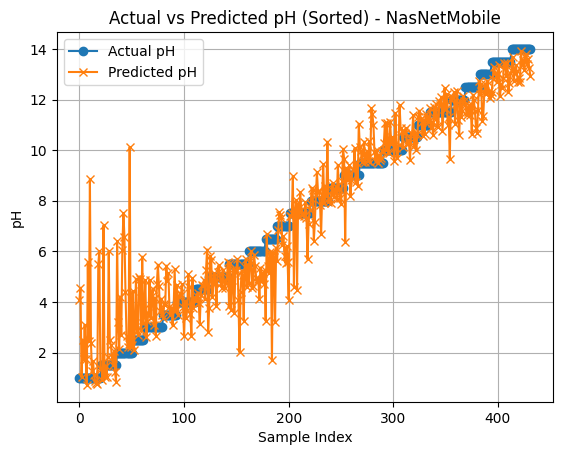

In [16]:
import numpy as np

sorted_indices = np.argsort(y_val)
plt.plot(np.array(y_val)[sorted_indices], label='Actual pH', marker='o')
plt.plot(y_pred[sorted_indices], label='Predicted pH', marker='x')
plt.title("Actual vs Predicted pH (Sorted) - NasNetMobile")
plt.xlabel("Sample Index")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.savefig("NasNetMobile_actualvspredicted_sorted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

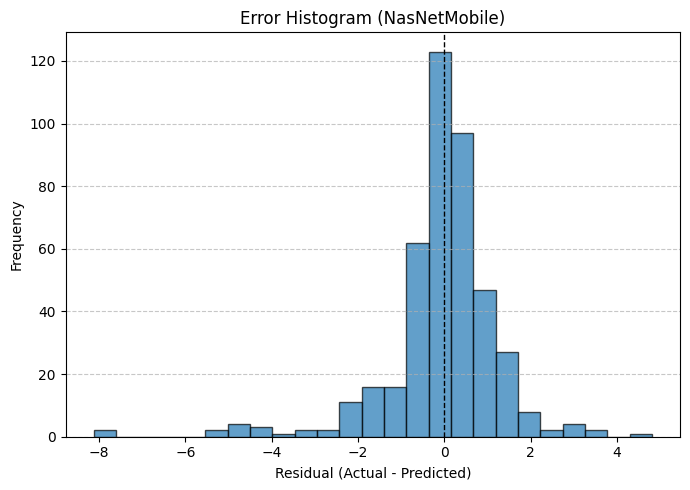

In [17]:
import matplotlib.pyplot as plt

# Residuals (errors)
residuals = y_val - y_pred

# Error histogram
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=25, edgecolor='black', alpha=0.7)
plt.axvline(0, color='k', linestyle='--', linewidth=1)  # reference line at 0
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Error Histogram (NasNetMobile)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("NasNetMobile_error_histogram.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

In [18]:
from tensorflow.keras.models import load_model
from google.colab import files

# Save the entire model
model_path = "NasNetMobile_regression_model_latest.h5"
model.save(model_path)

# Download the model file
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>